In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# Define dataset path
real_bearing_path = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Paderborn_all_CWT"

# Define transformations
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
dataset_real = ImageFolder(root=real_bearing_path, transform=image_transforms)

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(dataset_real))
test_size = len(dataset_real) - train_size
train_dataset_real, test_dataset_real = random_split(dataset_real, [train_size, test_size])

# Create DataLoaders
batch_size = 8
train_dataloader_real = DataLoader(train_dataset_real, batch_size=batch_size, shuffle=True)
test_dataloader_real = DataLoader(test_dataset_real, batch_size=batch_size, shuffle=False)

# Define Model
class BearingFaultClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(BearingFaultClassifier, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove FC layer

        # Attention Mechanism
        self.attn_q = nn.Linear(512, 512)
        self.attn_k = nn.Linear(512, 512)
        self.attn_v = nn.Linear(512, 512)
        self.attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Bi-LSTM
        self.lstm = nn.LSTM(input_size=512, hidden_size=512, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(0.5)  # Increase dropout
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet(x)  
        x = x.view(x.shape[0], -1, 512)  # Flatten

        q, k, v = self.attn_q(x), self.attn_k(x), self.attn_v(x)
        x, _ = self.attn(q, k, v)

        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Get last LSTM output

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BearingFaultClassifier(num_classes=3).to(device)

# Define Loss and Optimizer
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Training Loop
num_epochs = 30
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 7

for epoch in range(num_epochs):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for batch_X, batch_y in train_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)

    scheduler.step()  # Adjust learning rate
    train_acc = 100 * correct_train / total_train
    train_loss = total_train_loss / len(train_dataloader_real)

    # Validation Phase
    model.eval()
    total_val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for batch_X, batch_y in test_dataloader_real:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss = total_val_loss / len(test_dataloader_real)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_artificial.pth")


Epoch [1/30] - Train Acc: 72.03% | Val Acc: 86.98%
Epoch [2/30] - Train Acc: 85.17% | Val Acc: 84.67%
Epoch [3/30] - Train Acc: 88.27% | Val Acc: 92.34%
Epoch [4/30] - Train Acc: 89.42% | Val Acc: 94.09%
Epoch [5/30] - Train Acc: 91.36% | Val Acc: 93.17%
Epoch [6/30] - Train Acc: 92.35% | Val Acc: 94.83%
Epoch [7/30] - Train Acc: 92.24% | Val Acc: 95.94%
Epoch [8/30] - Train Acc: 94.25% | Val Acc: 96.49%
Epoch [9/30] - Train Acc: 94.73% | Val Acc: 93.72%
Epoch [10/30] - Train Acc: 95.43% | Val Acc: 96.77%
Epoch [11/30] - Train Acc: 95.73% | Val Acc: 96.49%
Epoch [12/30] - Train Acc: 95.31% | Val Acc: 96.86%
Epoch [13/30] - Train Acc: 95.31% | Val Acc: 96.40%
Epoch [14/30] - Train Acc: 95.31% | Val Acc: 96.49%
Epoch [15/30] - Train Acc: 93.65% | Val Acc: 94.74%
Epoch [16/30] - Train Acc: 94.09% | Val Acc: 91.23%
Epoch [17/30] - Train Acc: 90.34% | Val Acc: 93.54%
Epoch [18/30] - Train Acc: 90.58% | Val Acc: 93.26%
Epoch [19/30] - Train Acc: 92.05% | Val Acc: 91.60%
Epoch [20/30] - Train

In [2]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        ce_loss = self.ce_loss(logits, labels)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Replace criterion
criterion = FocalLoss()


In [4]:
# Get class names from the dataset
class_labels_real = dataset_real.classes
print("Class Labels:", class_labels_real)


Class Labels: ['IR Artificial', 'Normal', 'OR Artificial']


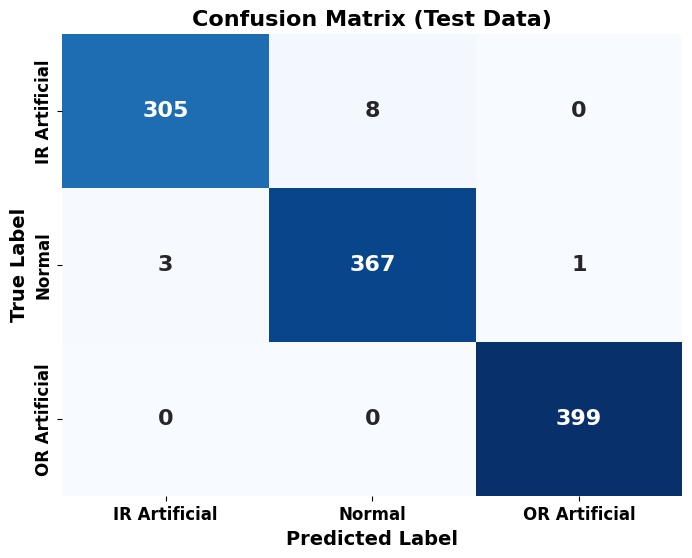


Classification Report:
                precision    recall  f1-score   support

IR Artificial       0.99      0.97      0.98       313
       Normal       0.98      0.99      0.98       371
OR Artificial       1.00      1.00      1.00       399

     accuracy                           0.99      1083
    macro avg       0.99      0.99      0.99      1083
 weighted avg       0.99      0.99      0.99      1083



In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ensure model is in evaluation mode
model.eval()

# Get test predictions
test_preds = []
test_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_labels_real)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_real, yticklabels=class_labels_real, 
            cbar=False, annot_kws={"size": 16, "fontweight": "bold"})  # Bigger font for better readability

# Labels and title
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix (Test Data)', fontsize=16, fontweight='bold')

# Make axis labels bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save & Show
#plt.savefig("confusion_matrix_test.png", dpi=1000)  # High-resolution save
plt.show()

# Print Classification Report
print("\nClassification Report:\n", report)


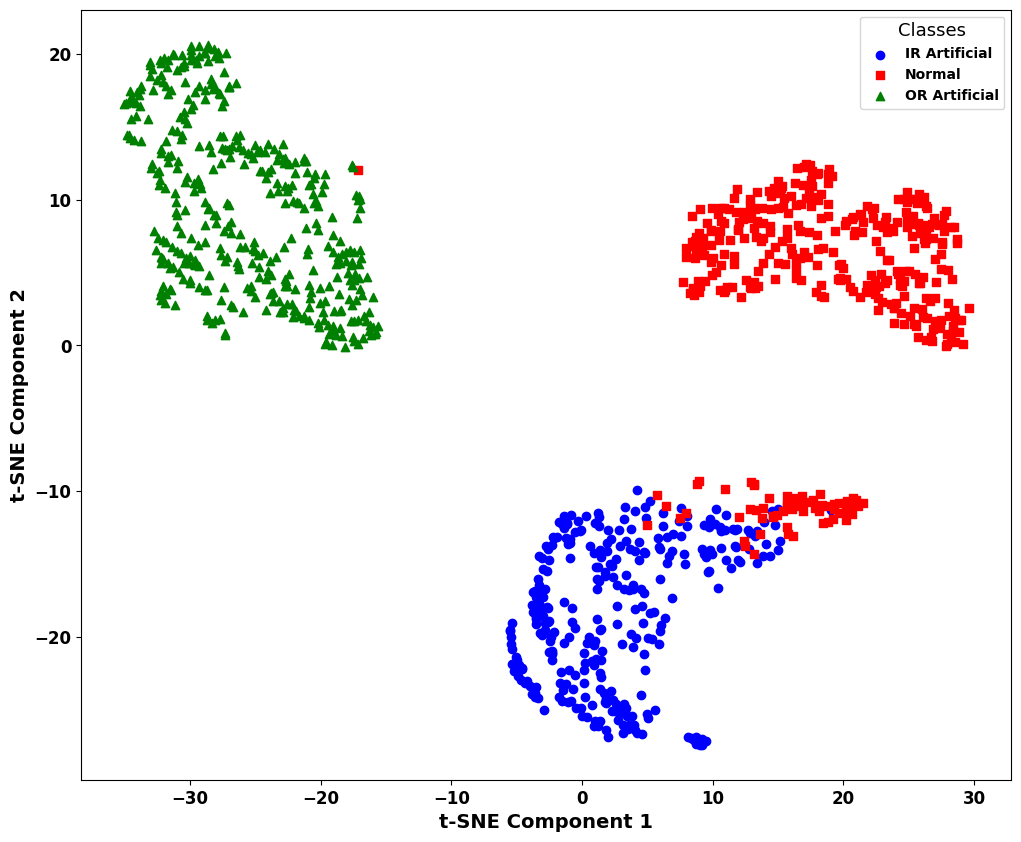

In [22]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

# Extract test features
features_list = []
labels_list = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X = batch_X.to(device)
        features = model.resnet(batch_X)  # Extract ResNet features
        features = features.view(features.size(0), -1)  # Flatten to (batch_size, 512)
        features_list.append(features.cpu().numpy())
        labels_list.append(batch_y.cpu().numpy())

# Stack all feature vectors and labels
features_array = np.vstack(features_list)
labels_array = np.concatenate(labels_list)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=60, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# Plot settings
plt.figure(figsize=(12, 10))
class_colors = ['blue', 'red', 'green']  # Colors for IR Real, Normal, OR Real
class_markers = ['o', 's', '^']  # Circle, Square, Triangle
for i, class_name in enumerate(class_labels_real):
    mask = (labels_array == i)
    plt.scatter(features_tsne[mask, 0], features_tsne[mask, 1],
                label=class_name,
                alpha=1,
                color=class_colors[i],
                marker=class_markers[i]
                )  # Bigger size for clarity

# Final touches
#plt.title('t-SNE of Test Features (Real Bearing Faults)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='13')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')


# Save & Show
plt.savefig("tsne_artiicial_bearing_test.png", dpi=1000)  # Save high-resolution image
plt.show()


In [12]:
print(f"Total Samples in t-SNE Plot: {features_array.shape[0]}")
print(f"Expected Test Samples: {len(test_dataset_real)}")


Total Samples in t-SNE Plot: 1083
Expected Test Samples: 1083


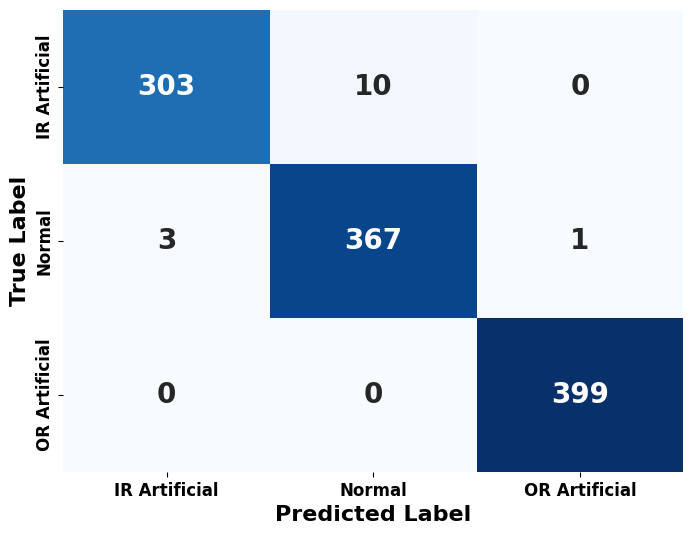


Classification Report:
                precision    recall  f1-score   support

IR Artificial       0.99      0.97      0.98       313
       Normal       0.97      0.99      0.98       371
OR Artificial       1.00      1.00      1.00       399

     accuracy                           0.99      1083
    macro avg       0.99      0.99      0.99      1083
 weighted avg       0.99      0.99      0.99      1083



In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ensure model is in evaluation mode
model.eval()

# Get test predictions
test_preds = []
test_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_labels_real)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_real, yticklabels=class_labels_real, 
            cbar=False, annot_kws={"size": 20, "fontweight": "bold"})  # Bigger font for better readability

# Labels and title
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')
#plt.title('Confusion Matrix (Test Data)', fontsize=16, fontweight='bold')

plt.setp(plt.gca().get_xticklabels(), fontweight='bold')
plt.setp(plt.gca().get_yticklabels(), fontweight='bold')

# Make axis labels bold
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save & Show
plt.savefig("confusion_matrix_test.png", dpi=1000)  # High-resolution save
plt.show()

# Print Classification Report
print("\nClassification Report:\n", report)


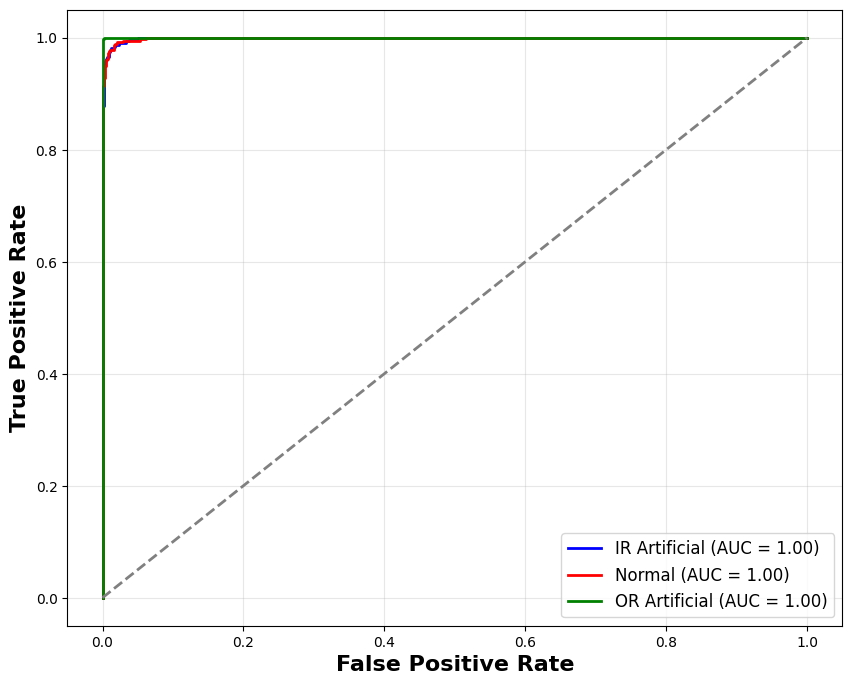

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels & predictions to NumPy arrays
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

# Binarize labels for multi-class ROC
num_classes = len(class_labels_real)  # 3 classes: IR Real, Normal, OR Real
test_labels_bin = label_binarize(test_labels, classes=range(num_classes))

# Compute probability scores for each class
with torch.no_grad():
    test_probs = []
    for batch_X, _ in test_dataloader_real:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)  # Get class probabilities (logits)
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert to probabilities
        test_probs.extend(probs.cpu().numpy())

test_probs = np.array(test_probs)

# Compute ROC curve & AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, class_name in enumerate(class_labels_real):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line

plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')

#plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

# Save high-resolution image
plt.savefig("roc_curve_test.png", dpi=1000)
plt.show()


In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Compute overall accuracy
accuracy = np.trace(cm) / np.sum(cm)

# Compute TPR, FPR, FNR, and FDR
TPR = np.diag(cm) / np.sum(cm, axis=1)  # True Positive Rate (Recall)
FPR = np.sum(cm, axis=0) - np.diag(cm)  # False Positive Rate
FPR = FPR / np.sum(cm, axis=0)  # Normalize

FNR = np.sum(cm, axis=1) - np.diag(cm)  # False Negative Rate
FNR = FNR / np.sum(cm, axis=1)  # Normalize

FDR = np.sum(cm, axis=0) - np.diag(cm)  # False Discovery Rate
FDR = FDR / (np.sum(cm, axis=0) + 1e-9)  # Avoid division by zero

# Compute precision, recall, and F1-score
report = classification_report(test_labels, test_preds, target_names=class_labels_real, output_dict=True)
precision = [report[class_name]['precision'] for class_name in class_labels_real]
f1_scores = [report[class_name]['f1-score'] for class_name in class_labels_real]

# Print all metrics
print("\n### Paper Metrics ###")
print(f"True Positive Rate (TPR) per Class: {np.round(TPR, 4)}")
print(f"False Positive Rate (FPR) per Class: {np.round(FPR, 4)}")
print(f"False Negative Rate (FNR) per Class: {np.round(FNR, 4)}")
print(f"False Discovery Rate (FDR) per Class: {np.round(FDR, 4)}")
print(f"Precision per Class: {np.round(precision, 4)}")
print(f"F1 Score per Class: {np.round(f1_scores, 4)}")

print(f"\nOverall Accuracy: {accuracy:.4f}")

# Print classification report
print("\n### Full Classification Report ###\n")
print(classification_report(test_labels, test_preds, target_names=class_labels_real))



### Paper Metrics ###
True Positive Rate (TPR) per Class: [0.9681 0.9892 1.    ]
False Positive Rate (FPR) per Class: [0.0098 0.0265 0.0025]
False Negative Rate (FNR) per Class: [0.0319 0.0108 0.    ]
False Discovery Rate (FDR) per Class: [0.0098 0.0265 0.0025]
Precision per Class: [0.9902 0.9735 0.9975]
F1 Score per Class: [0.979  0.9813 0.9987]

Overall Accuracy: 0.9871

### Full Classification Report ###

               precision    recall  f1-score   support

IR Artificial       0.99      0.97      0.98       313
       Normal       0.97      0.99      0.98       371
OR Artificial       1.00      1.00      1.00       399

     accuracy                           0.99      1083
    macro avg       0.99      0.99      0.99      1083
 weighted avg       0.99      0.99      0.99      1083

